<h1 style="font-size:200%; font-family:cursive; color:navy;">1. Import Required Libraries & Dataset</h1>

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
!pip install transformers
import transformers
from transformers import AutoModel, BertTokenizerFast

device = torch.device("cuda")

from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.9 MB/s eta 0:00:00
Mounted at /content/drive


<ul>
    <li style="font-size:150%;">The dataset consists of two columns – “label” and “text”. The column “text” contains the message body and the “label” is a binary variable where 1 means spam and 0 means the message is not a spam.</li>
</ul>

<h1 style="font-size:200%; font-family:cursive; color:navy;">3. Import Bert - base- uncased</h1>

In [4]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('zhihan1996/DNA_bert_6')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('zhihan1996/DNA_bert_6')

In [9]:
import pickle

#drive_path = "/content/drive/MyDrive/Virus-DNA-classification-BERT-main/old_code/data10/data3"
drive_path = "/content/drive/MyDrive/old_code/data10/data3/data3"

with open(drive_path + 'train_text_3.pkl', 'rb') as f:
    train_text = pickle.load(f)
with open(drive_path + 'temp_text_3.pkl', 'rb') as f:
    temp_text = pickle.load(f)
with open(drive_path + 'train_labels_3.pkl', 'rb') as f:
    train_labels = pickle.load(f)
with open(drive_path + 'temp_labels_3.pkl', 'rb') as f:
    temp_labels = pickle.load(f)

with open(drive_path + 'val_text_3.pkl', 'rb') as f:
    val_text = pickle.load(f)
with open(drive_path + 'test_text_3.pkl', 'rb') as f:
    test_text = pickle.load(f)
with open(drive_path + 'val_labels_3.pkl', 'rb') as f:
    val_labels = pickle.load(f)
with open(drive_path + 'test_labels_3.pkl', 'rb') as f:
    test_labels = pickle.load(f)

<h1 style="font-size:200%; font-family:cursive; color:navy;">4. Tokenize & Encode the Sequences</h1>

<u><h2 style="font-size:170%; font-family:cursive;">Which Tokenization strategy is used by BERT?</h2></u>

<p style="font-size:150%; font-family:verdana;">BERT uses WordPiece tokenization. The vocabulary is initialized with all the individual characters in the language, and then the most frequent/likely combinations of the existing words in the vocabulary are iteratively added.</p>
<br>
<u><h2 style="font-size:170%; font-family:cursive;">What is the maximum sequence length of the input?</h2></u>

<p style="font-size:150%; font-family:verdana;">The maximum sequence length of the input = 512</p>

In [10]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=512,
    padding=True,  # pad to max len
    truncation=True,  # truncate to max len
    return_attention_mask=True,
    return_tensors="pt"
)



In [12]:
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=512,
    padding=True,  # pad to max len
    truncation=True,  # truncate to max len
    return_attention_mask=True,
    return_tensors="pt"
)

In [13]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=512,
    padding=True,  # pad to max len
    truncation=True,  # truncate to max len
    return_attention_mask=True,
    return_tensors="pt",
)

# Load Tokens

<h1 style="font-size:200%; font-family:cursive; color:navy;">5. List to Tensors</h1>

In [14]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

<ipython-input-14-40b617136a1e>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_seq = torch.tensor(tokens_train['input_ids'])
<ipython-input-14-40b617136a1e>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_mask = torch.tensor(tokens_train['attention_mask'])
<ipython-input-14-40b617136a1e>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_seq = torch.tensor(tokens_val['input_ids'])
<ipython-input-14-40b617136a1e>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

<h1 style="font-size:200%; font-family:cursive; color:navy;">6. Data Loader</h1>

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [16]:
train_dataloader

<h1 style="font-size:200%; font-family:cursive; color:navy;">7. Model Architecture</h1>

In [17]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [18]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,3)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [19]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [20]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
from sklearn.utils.class_weight import compute_class_weight
print(np.unique(train_labels))
#compute the class weights
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(train_labels), y = train_labels)

print("Class Weights:",class_weights)

[0 1 2]
Class Weights: [1. 1. 1.]


In [22]:

# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 500

<h1 style="font-size:200%; font-family:cursive; color:navy;">8. Fine - Tune</h1>

In [23]:
# function to train the model
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [24]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(tokens_val)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [25]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    #save the best model
    if epoch % 10 == 0 and valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), drive_path + 'saved_weights_3.pkl')
        with open(drive_path + 'train_losses_3.pkl', 'wb') as f:
            pickle.dump(train_losses, f)
        with open(drive_path + 'valid_losses_3.pkl', 'wb') as f:
            pickle.dump(valid_losses, f)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 500

Evaluating...

Training Loss: 1.095
Validation Loss: 2.887

 Epoch 2 / 500

Evaluating...

Training Loss: 1.089
Validation Loss: 2.868

 Epoch 3 / 500

Evaluating...

Training Loss: 1.082
Validation Loss: 2.842

 Epoch 4 / 500

Evaluating...

Training Loss: 1.076
Validation Loss: 2.821

 Epoch 5 / 500

Evaluating...

Training Loss: 1.070
Validation Loss: 2.803

 Epoch 6 / 500

Evaluating...

Training Loss: 1.067
Validation Loss: 2.785

 Epoch 7 / 500

Evaluating...

Training Loss: 1.060
Validation Loss: 2.763

 Epoch 8 / 500

Evaluating...

Training Loss: 1.055
Validation Loss: 2.748

 Epoch 9 / 500

Evaluating...

Training Loss: 1.051
Validation Loss: 2.730

 Epoch 10 / 500

Evaluating...

Training Loss: 1.049
Validation Loss: 2.714

 Epoch 11 / 500

Evaluating...

Training Loss: 1.043
Validation Loss: 2.701

 Epoch 12 / 500

Evaluating...

Training Loss: 1.043
Validation Loss: 2.680

 Epoch 13 / 500

Evaluating...

Training Loss: 1.034
Validation Loss: 2.665

 Epoch 

In [26]:
with open(drive_path + 'train_losses_3.pkl', 'rb') as f:
        train_losses = pickle.load(f)
with open(drive_path + 'valid_losses_3.pkl', 'rb') as f:
        valid_losses = pickle.load(f)

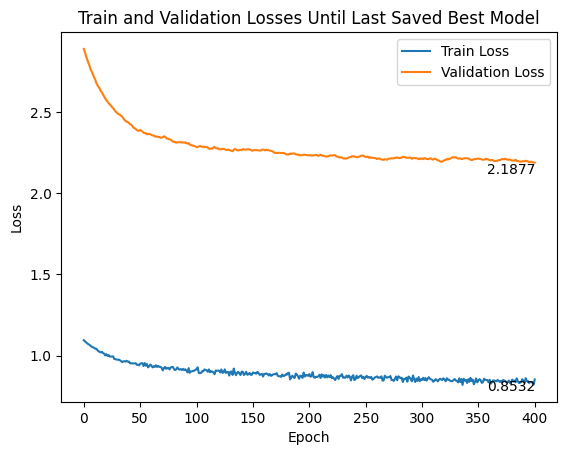

In [28]:
import matplotlib.pyplot as plt

# Plot train_losses and valid_losses against their indices
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')

last_train_loss = round(train_losses[-1], 4)
last_valid_loss = round(valid_losses[-1], 4)

plt.text(len(train_losses), train_losses[-1], str(last_train_loss), ha='right', va='top')
plt.text(len(valid_losses), valid_losses[-1], str(last_valid_loss), ha='right', va='top')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Losses Until Last Saved Best Model')

# Add a legend to differentiate train and validation losses
plt.legend()

# Show the plot
plt.show()

In [29]:
#load weights of best model

#path = "/content/drive/MyDrive/Virus-DNA-classification-BERT-main/old_code/data10/data3/saved_weights_3.pkl"
path = drive_path + "saved_weights_3.pkl"

model.load_state_dict(torch.load(path))

<All keys matched successfully>

<h1 style="font-size:200%; font-family:cursive; color:navy;">9. Make Predictions</h1>

In [31]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [35]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.47      0.21      0.29        75
           1       0.62      0.69      0.65        75
           2       0.48      0.68      0.56        75

    accuracy                           0.53       225
   macro avg       0.52      0.53      0.50       225
weighted avg       0.52      0.53      0.50       225



<center><h1 style="font-size:300%; font-family:cursive; color:black; background:skyblue; padding:15px; border:solid;">REFERENCES & CREDITS</h1></center>

<ol>
    <li style="font-size:150%;"><a href="https://www.reddit.com/r/MachineLearning/comments/ao23cp/p_how_to_use_bert_in_kaggle_competitions_a/">How to use BERT in Kaggle competitions - Reddit Thread</a></li>
    <li style="font-size:150%;"><a href="http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">A visual guide to using BERT by Jay Alammar</a></li>
    <li style="font-size:150%;"><a href="https://www.analyticsvidhya.com/blog/2019/09/demystifying-bert-groundbreaking-nlp-framework/">Demystifying BERT: Groundbreaking NLP Framework by Mohd Sanad Zaki Rizvi</a></li>
    <li style="font-size:150%;"><a href="https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03">BERT for Dummies step by step tutorial by Michel Kana</a></li>
</ol>

<br>
<center><h1 style="font-size:300%; font-family:cursive; color:black; background:skyblue; padding:15px; border:solid;">CONCLUSION</h1></center>

<p style="font-size:150%; font-family:verdana;">BERT is undoubtedly a breakthrough in the use of Machine Learning for Natural Language Processing. The fact that it’s approachable and allows fast fine-tuning will likely allow a wide range of practical applications in the future. In this Notebook we have discussed about BERT (Theoritical + Practical Part).</p>

<center><h1 style="font-size:200%; color:green;">Please give this kernel an UPVOTE to show your appreciation, if you find it useful.</h1></center>